In [227]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from imblearn.over_sampling import SMOTE

from autograd import grad
import autograd.numpy as np

df = pd.read_csv("Non_Textual_and_Textual_Features.csv")

# Function to create labels based on the Boolean columns BUG and BIC of the dataset. Necessary for our dataset, might be optional for others.
def label_bool(is_bug,bic):
    if(is_bug==1 and bic==1):
        return 1 # Intrinsic
    elif(is_bug==1 and bic==0):
        return 0 # Extrinsic
    else:
        return -1 # Non-bug
    
df["Label"]=df.apply(lambda x: label_bool(x['BUG'],x['BIC']),axis=1)
df = df[df['Label']>-1]

df.head()

,Unnamed: 0.2,commit_id,author_date,bugcount,fixcount,la,ld,nf,nd,ns,...,BugId,Project,FixHashId,BUG,BIC,Comments,title,description,BFC_message,Label
0,0,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1395160653,0.0,1.0,29,12,2,2,1,...,1284162,neutron,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1,1,NaN,"Bug #1284162 in neutron: ""Cisco plugin fails t...",When the Cisco nexus plugin is configured on D...,Cisco plugin fails with ParseError no elem fou...,1
2,2,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1401120475,NaN,1.0,16,4,4,3,1,...,1322180,nova,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1,0,"""Legacy bdm in incoming parameters contains a ...","Bug #1322180 in OpenStack Compute (nova): ""Fai...",Launting an instance from bootable volume pass...,Run instance root device determination fix.\n\...,0
3,3,00f5125745dc72afbc9aeade8b780d7a3be49a30,1394439616,NaN,1.0,5,1,2,2,1,...,1288926,nova,00f5125745dc72afbc9aeade8b780d7a3be49a30,1,1,bug rebooting,"Bug #1288926 in OpenStack Compute (nova): ""inc...",This is using the latest nova from trunk. In o...,Don't allow reboot when instance in rebooting_...,1
4,4,011d99f300ea5d5f4ce48023bd04a795a4872287,1369792347,3.0,1.0,87,47,2,2,1,...,1175695,neutron,011d99f300ea5d5f4ce48023bd04a795a4872287,1,1,,"Bug #1175695 in neutron: ""L3 agent restart cau...","When L3 agent is restarted, it destroys all ex...",L3 Agent restart causes network outage\n\nWhen...,1
5,5,0125cf7815acb677b619905e2d9d258a9bae1c48,1407713999,NaN,1.0,3,2,2,2,1,...,1355759,neutron,0125cf7815acb677b619905e2d9d258a9bae1c48,1,1,NaN,"Bug #1355759 in neutron: ""L2populationRpcCallB...",L2populationRpcCallBackTunnelMixin get_agent_p...,"l2pop: get_agent_ports: Don't yield (None, {})...",1


# Data Clean up and processing

- Converting boolean columns values to either 1 (true) or 0 (false)
- Replacing NaN Values by zero (0)
- Normalizing the data (scaling it down twice)
- Defining the Independent and dependent variable

In [228]:
# Converting boolean columns to 1 and 0
df['revd'] = df['revd'].apply(lambda x: 1 if x==True else 0)
df['self'] = df['self'].apply(lambda x: 1 if x==True else 0)

#Feature selection 3:33 all featurs
print(df.columns[3:33])
columns=list(df.columns[3:33])

# Defining x and y
x = df[columns]
y = df['Label']

x = x.fillna(0)                                  # Replacing NaN values with the mean of that column
x_norm = (x-x.min())/(x.max()-x.min())**2        # Normalizing the data
x= x_norm

# Converting to numpy array
x = np.array(x)
y = np.array(y)

Index(['bugcount', 'fixcount', 'la', 'ld', 'nf', 'nd', 'ns', 'ent', 'revd',
       'nrev', 'rtime', 'tcmt', 'hcmt', 'self', 'ndev', 'age', 'nuc', 'app',
       'aexp', 'rexp', 'oexp', 'arexp', 'rrexp', 'orexp', 'asexp', 'rsexp',
       'osexp', 'asawr', 'rsawr', 'osawr'],
      dtype='object')


# Train Test Splitting the dataset

In [229]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)
print(x_train.shape, y_train.shape)

(892, 30) (892,)


In [322]:
def class_balancing(X, y):
    # Perform class balancing using SMOTE
    smote = SMOTE()
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

def model(x,w):
    # generate polynomial function of degree = d
    polynomial_features = PolynomialFeatures(d)
    x_poly = polynomial_features.fit_transform(x)
    return np.dot(x_poly,w)
    #return w[0]+np.dot(x_poly,w[1:])

def sigmoid(t):
    return 1/(1+np.exp(-t))

def cross_entropy(w,x,y):
    a = sigmoid(model(x,w))
    ind = np.argwhere(y==0)[:,0]
    cost = -5*np.sum(np.log(1-a[ind]))
    
    ind = np.argwhere(y==1)[:,0]
    cost -= np.sum(np.log(a[ind]))
    cost += lambda_*norm(w[1:],1)
    return cost/y.size

def gradient_descent(g,step,max_iter,w):
    gradient = grad(g)
    weight_history = [w]
    cost_history = [g(w)]
    
    for k in range(max_iter):
        grad_eval = gradient(w) #get the gradient
        grad_eval_norm = grad_eval/np.linalg.norm(grad_eval)  #Normalized gradient descent
        w = w - step*grad_eval_norm
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history, cost_history

def c(w):
    c = cross_entropy(w,x_train,y_train)
    return c

(1332, 30)
['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x13' 'x14' 'x15' 'x16' 'x17' 'x18' 'x19' 'x20' 'x21' 'x22' 'x23' 'x24'
 'x25' 'x26' 'x27' 'x28' 'x29']
31
[20.         18.94736842 17.89473684 16.84210526 15.78947368 14.73684211
 13.68421053 12.63157895 11.57894737 10.52631579  9.47368421  8.42105263
  7.36842105  6.31578947  5.26315789  4.21052632  3.15789474  2.10526316
  1.05263158  0.        ]


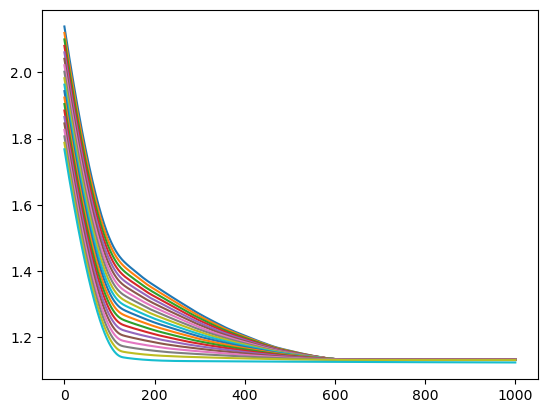

In [342]:
iter = 1000
print(x.shape)

global d, lambda_
d = 1
polynomial_features = PolynomialFeatures(d)
x_poly = polynomial_features.fit_transform(x)
print(polynomial_features.get_feature_names_out())
print(x_poly.shape[1])
w = np.array(np.random.rand(x_poly.shape[1],1))

lambda_array = np.linspace(20,0,20)
print(lambda_array)
b_array = []
a_array = []
for lambda_ in lambda_array:
    a, b = gradient_descent(c,0.01,iter,w)
    a_array.append(a)
    b_array.append(b)
    #plt.plot(b)
    #plt.show()
plt.figure(1)
for i in range(len(b_array)):
    plt.plot(b_array[i])
plt.show()

In [346]:
print(a_array[0][iter])
print(len(df.columns[3:33]))
tally = dict(zip(df.columns[3:33],a_array[10][iter][1:]))
print(tally)

[[ 5.67220674e-02]
 [ 4.08373203e-04]
 [-1.87293276e-03]
 [ 1.42961851e-03]
 [-1.20130923e-03]
 [-6.91883317e-05]
 [-9.99110425e-04]
 [-1.96301492e-03]
 [-9.73749417e-05]
 [-5.88440159e-04]
 [-8.76624303e-04]
 [ 1.22537915e-03]
 [-1.02415379e-03]
 [ 6.34625644e-04]
 [ 1.39206005e-03]
 [-6.58239888e-04]
 [-1.17947607e-03]
 [ 1.06129656e-03]
 [ 1.35659495e-03]
 [-9.26543484e-04]
 [-8.02008902e-04]
 [ 9.96563922e-04]
 [ 1.15824790e-03]
 [-6.57569049e-04]
 [ 2.19109239e-04]
 [-1.14864329e-03]
 [ 1.29805795e-03]
 [ 1.26938841e-03]
 [-7.37885471e-05]
 [ 1.35637513e-03]
 [-8.69544477e-04]]
30
{'bugcount': array([5.81757448e-05]), 'fixcount': array([-0.00021137]), 'la': array([-0.00122758]), 'ld': array([-0.00113457]), 'nf': array([-0.00113766]), 'nd': array([0.00109524]), 'ns': array([-0.00136816]), 'ent': array([0.00274134]), 'revd': array([0.00222541]), 'nrev': array([-0.00063222]), 'rtime': array([-0.00112039]), 'tcmt': array([-0.00117961]), 'hcmt': array([-1.1345451e-05]), 'self': array([

In [325]:
y_pred = np.sign(sigmoid(model(x_test, a[iter]))- 0.5)/2 +0.5

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

print(classification_report(y_test, y_pred))

[[  7  25]
 [ 46 122]]
0.645
              precision    recall  f1-score   support

           0       0.13      0.22      0.16        32
           1       0.83      0.73      0.77       168

    accuracy                           0.65       200
   macro avg       0.48      0.47      0.47       200
weighted avg       0.72      0.65      0.68       200



In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(x_train, y_train)

y_pred2 = classifier.predict(x_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))

In [289]:
print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)
print(x_test.shape, y_test.shape)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, stratify=y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1332, 30) (1332,)
(400, 30) (400,)
(932, 30) (932,)
(200, 30) (200,)
(200, 30) (200,)


In [210]:
iter = 400
print(x.shape)

global d, lambda_
d = 1
polynomial_features = PolynomialFeatures(d)
x_poly = polynomial_features.fit_transform(x)
print(x_poly.shape[1])
w = np.array(np.random.rand(x_poly.shape[1]+1,1))

lambda_array = np.linspace(1,0,11)
print(lambda_array)
b_array = []
a_array = []
for lambda_ in lambda_array:
    a, b = gradient_descent(c,0.01,iter,w)
    a_array.append(a)
    b_array.append(b)
    
plt.figure(1)
for i in range(len(b_array)):
    plt.plot(b_array[i])
plt.show()

[[3.13932845e-01]
 [7.65747297e-01]
 [1.75796546e-01]
 [6.62546765e-01]
 [1.10935496e-02]
 [3.41176433e-01]
 [1.58867868e-01]
 [9.33421789e-01]
 [7.93239742e-01]
 [7.03806198e-01]
 [9.03040953e-01]
 [9.70152691e-01]
 [6.68017417e-01]
 [2.23422734e-01]
 [6.93288743e-01]
 [3.62737187e-01]
 [8.86666378e-01]
 [3.53316884e-01]
 [4.86970048e-01]
 [1.08251811e-01]
 [3.98771640e-01]
 [8.12804568e-01]
 [8.18189992e-01]
 [1.45308919e-01]
 [6.96791332e-01]
 [7.58742603e-01]
 [4.28078869e-01]
 [1.78933410e-01]
 [6.12778336e-01]
 [7.64180217e-01]
 [2.34168588e-01]
 [9.47640608e-01]
 [7.20954947e-01]
 [9.13184584e-01]
 [3.54986115e-01]
 [4.03455179e-01]
 [5.29609789e-01]
 [5.64057088e-01]
 [8.50349812e-01]
 [5.89332841e-01]
 [7.40337358e-01]
 [9.53611532e-01]
 [3.57664161e-01]
 [2.76882103e-01]
 [3.57158512e-01]
 [3.70294309e-01]
 [9.30826395e-04]
 [5.98649428e-01]
 [2.43810832e-01]
 [3.38599141e-01]
 [9.39175869e-01]
 [2.62085006e-01]
 [9.96235781e-01]
 [6.19779716e-01]
 [2.31191831e-01]
 [1.887988